## A. Brief Summary of Top Insights

- **Daily Spikes**: Normal days see 30 K–80 K purchases; promo/new-drop days spike to 100 K–200 K.  
- **Seasonality**: Mid-year peaks (Jun–Jul) and winter troughs (Dec–Jan); Saturdays highest, Sundays/Mondays lowest.  
- **Anomaly Flags**: Residuals from a 7-day decomposition (resid > mean + 3 σ) perfectly mark “promo/new-drop” days.  
- **Trending Products**: Dresses, Sweaters, Trousers and Cardigans show 50×–467× growth in the last 8 weeks—ideal for freshness boosts.  
- **Co-Purchase Patterns**: Strong pairs like Bikini Top ↔ Swimwear Bottom and Denim variants enable item-to-item cross-sell recommendations.

---

## B. Detailed Insights

1. **Daily Volume & Spikes**  
   - Typical days: **30 K–80 K** purchases  
   - Occasional spikes: **100 K–200 K**, aligning with end-of-month or promotional/new-drop events.

2. **Trend & Seasonality**  
   - **Long-term trend**: Mid-year peaks (Jul 2019 & Jul 2020) and winter troughs (Dec–Jan).  
   - **Weekly cycle**: Saturdays highest (~48 K avg), Sundays/Mondays lowest (~38–39 K avg).  
   - **Monthly cycle**: Summer surges (Jun–Jul), winter lulls (Dec–Jan), plus a sharp Apr–May 2020 rebound (post-lockdown).

3. **Time-Series Decomposition & Anomalies**  
   - **Trend component** captures summer bumps and winter dips.  
   - **Seasonal component** shows a stable 7-day cycle (~±5 K swings).  
   - **Residuals** isolate spikes—resid > mean + 3·σ flags “promo/new-drop” days.

4. **Category-Level Patterns**  
   - **Sweaters**: Winter-only demand; near-zero summer sales.  
   - **Dresses**: Peaks in spring/summer (Jul 2019 & Jul 2020).  
   - **Trousers**: Steady year-round with mild mid-year uplift.  
   - **T-shirts & Tops**: Balanced all year, modest summer bumps.

5. **Basket-Size Distribution**  
   - Most “baskets” contain **1–10** items; long tail up to hundreds.  
   - Use to inform max recommendation list length.

6. **Inter-Purchase Times**  
   - ~70 % of repeat buys within **1–2 days**; very few beyond 30 days.  
   - Strong case for heavy recency weighting.

7. **Category Diversity per User**  
   - ~75 % of customers buy from **≤ 5** distinct product types; a small segment explores > 20.  
   - Adjust exploration vs. exploitation based on user diversity.

8. **Price Sensitivity by Segment**  
   - High-spenders’ avg price ≈ 0.046 vs. low-spenders ≈ 0.016 (∼ 3× difference).  
   - Tailor premium vs. value recommendations.

9. **Trending Products (Growth Analysis)**  
   - Top-growing SKUs over the last 8 weeks include **Dresses**, **Sweaters**, **Trousers**, **Cardigans** with growth up to **467×**.  
   - These summer-season items are prime for freshness boosts.

10. **Co-Purchase Patterns (Market-Basket Analysis)**  
   - Strong pairs: **Bikini Top ↔ Swimwear Bottom**, **Denim SKU variants**, **T-shirt duplicates**.  
   - Leverage these for item-to-item cross-sell recommendations.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
articles = pd.read_csv('articles.csv')
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions_train.csv')
transactions.to_parquet('transactions.parquet')
transactions_parquet = pd.read_parquet('transactions.parquet')

In [3]:
import datetime

def convert_to_date(s):
    """
    Memoization technique - very fast conversion to pure python dates
    """
    dates = {date:datetime.datetime.strptime(date,'%Y-%m-%d') for date in s.unique()}
    return s.map(dates)

In [4]:
transactions_parquet["t_dat"] = convert_to_date(transactions_parquet["t_dat"])
transactions_parquet["t_dat"] = pd.to_datetime(transactions_parquet["t_dat"])
transactions = transactions_parquet

In [5]:
tx = transactions
arts = articles
cust = customers

<Axes: title={'center': 'Daily Transactions'}, xlabel='t_dat'>

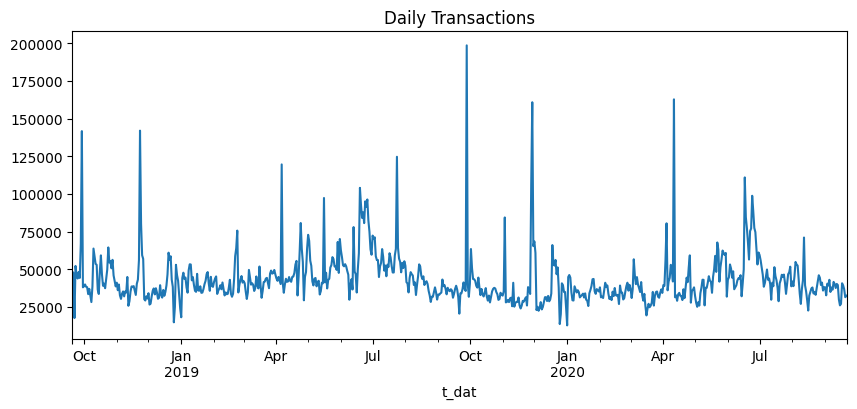

In [11]:
# Overall purchase volume over time
daily = tx.groupby("t_dat")["article_id"].count().rename("purchases")
daily.plot(figsize=(10,4), title="Daily Transactions")

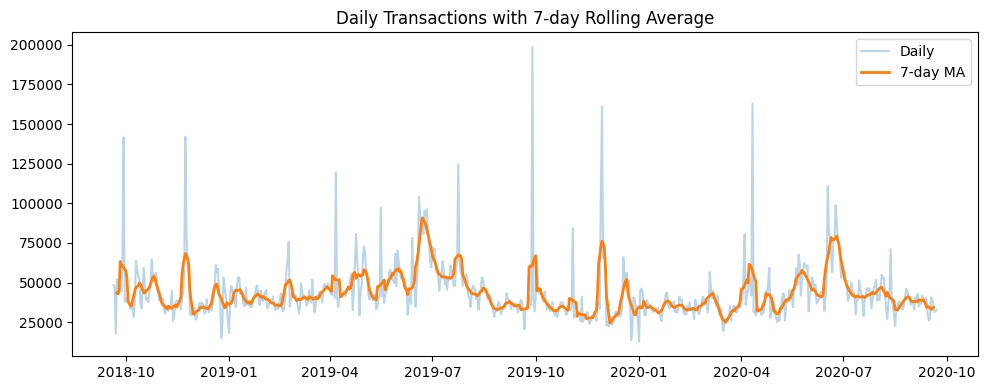

In [12]:
import matplotlib.pyplot as plt

# 7-day rolling
rolling7 = daily.rolling(window=7, center=True).mean()

plt.figure(figsize=(10,4))
plt.plot(daily.index, daily, alpha=0.3, label="Daily")
plt.plot(rolling7.index, rolling7, lw=2, label="7-day MA")
plt.title("Daily Transactions with 7-day Rolling Average")
plt.legend()
plt.tight_layout()
plt.show()


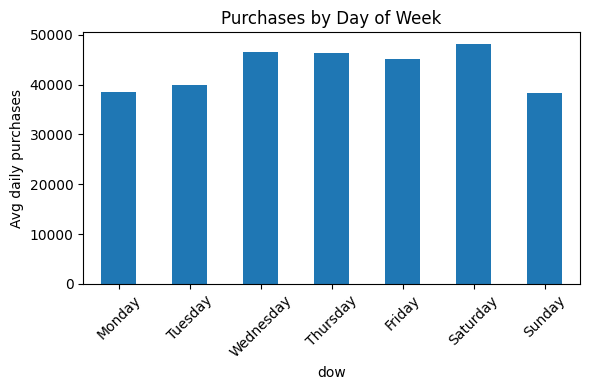

In [13]:
import pandas as pd

df = daily.reset_index().rename(columns={"t_dat":"date","purchases":"count"})
df["dow"] = df["date"].dt.day_name()

# Average purchases per weekday
dow_avg = df.groupby("dow")["count"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(6,4))
dow_avg.plot(kind="bar")
plt.ylabel("Avg daily purchases")
plt.title("Purchases by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/f7/6h7jh2f93wj8fn1lg8fb5g0c0000gn/T/ipykernel_77554/2412544614.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily.resample("M").mean()


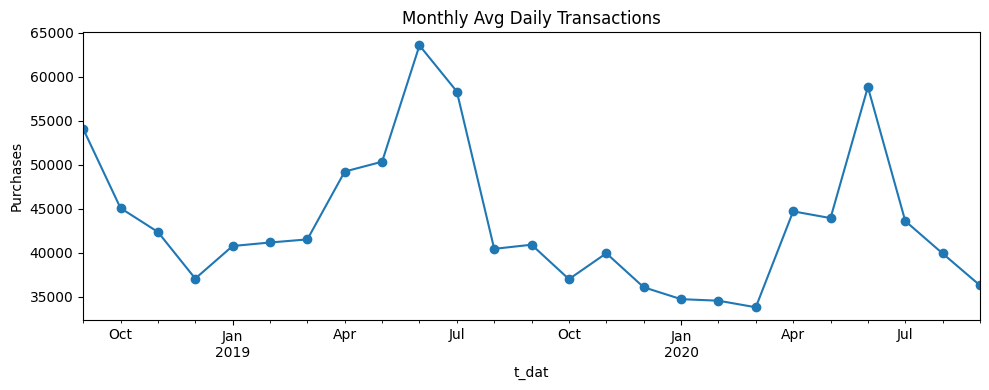

In [14]:
monthly = daily.resample("M").mean()

plt.figure(figsize=(10,4))
monthly.plot(marker="o")
plt.title("Monthly Avg Daily Transactions")
plt.ylabel("Purchases")
plt.tight_layout()
plt.show()


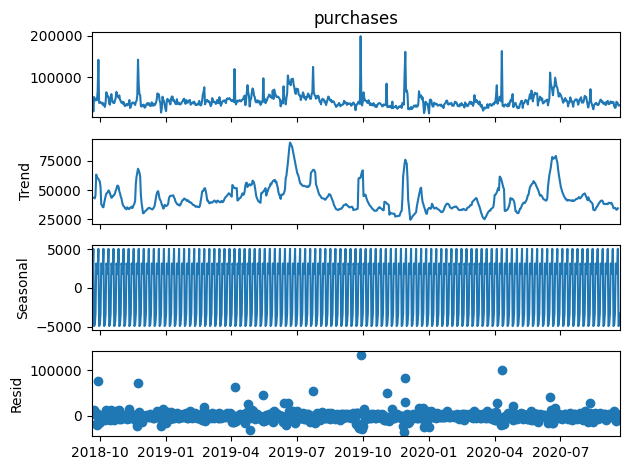

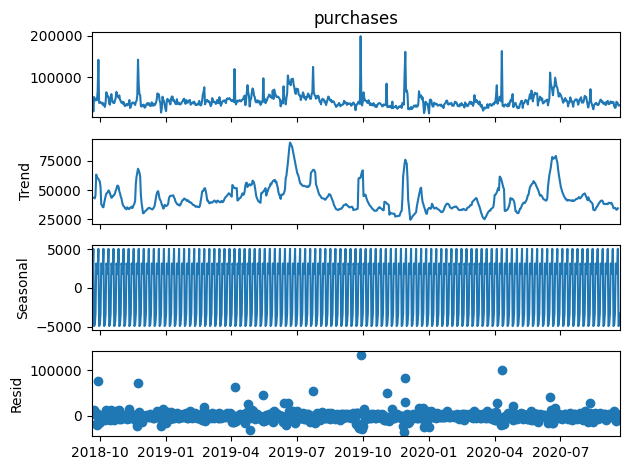

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(daily, model="additive", period=7)
decomp.plot()

In [ ]:
resid = decomp.resid.dropna()
threshold = resid.mean() + 3*resid.std()
anomalies = resid[resid > threshold]

<Axes: xlabel='t_dat'>

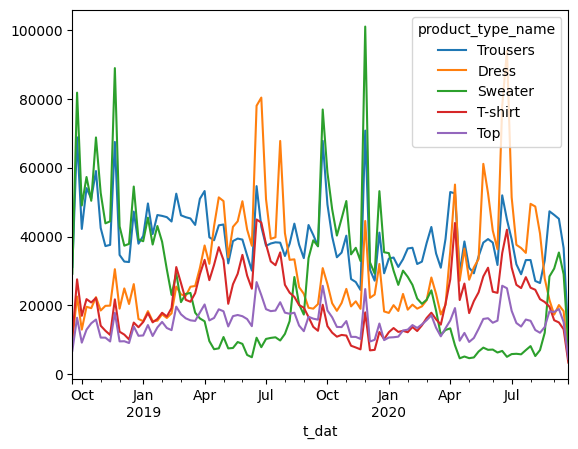

In [23]:
tx2 = tx.merge(arts[["article_id","product_type_name"]], on="article_id")
weekly = (tx2.set_index("t_dat")
            .groupby([pd.Grouper(freq="W"), "product_type_name"])
            .size().unstack().fillna(0))
top5 = weekly.sum().nlargest(5).index
weekly[top5].plot()


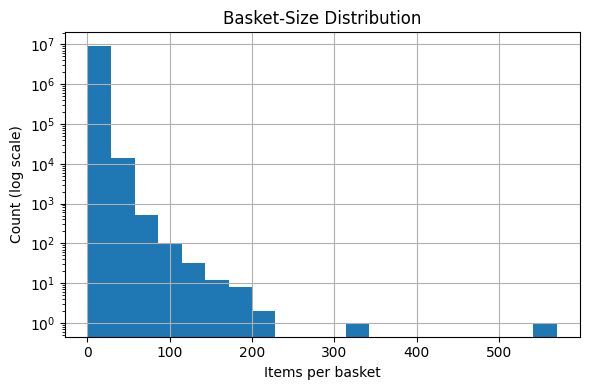

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Count items per customer–day
baskets = (
    tx.groupby(["customer_id", "t_dat"])
      .size()
      .reset_index(name="basket_size")
)

# 2. Plot distribution
plt.figure(figsize=(6,4))
baskets["basket_size"].hist(bins=20, log=True)
plt.xlabel("Items per basket")
plt.ylabel("Count (log scale)")
plt.title("Basket‐Size Distribution")
plt.tight_layout()
plt.show()


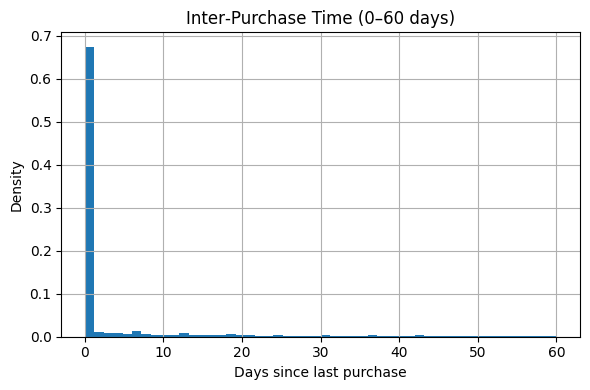

In [25]:
# 1. Sort and compute days between buys
tx_sorted = tx.sort_values(["customer_id","t_dat"])
tx_sorted["prev_date"] = tx_sorted.groupby("customer_id")["t_dat"].shift()
tx_sorted["days_since"] = (tx_sorted["t_dat"] - tx_sorted["prev_date"]).dt.days

# 2. Plot the distribution
plt.figure(figsize=(6,4))
tx_sorted["days_since"].dropna().hist(bins=50, range=(0,60), density=True)
plt.xlabel("Days since last purchase")
plt.ylabel("Density")
plt.title("Inter‐Purchase Time (0–60 days)")
plt.tight_layout()
plt.show()


In [14]:
# 1. Flag repeat buys per customer–item
tx["is_repeat"] = tx.duplicated(subset=["customer_id","article_id"], keep="first").astype(int)

# 2. Compute per‐customer repeat ratio
repeat_rate = (
    tx.groupby("customer_id")["is_repeat"]
      .mean()
      .rename("repeat_ratio")
)


In [15]:
repeat_rate.describe().round(2)

count    1362281.00
mean           0.10
std            0.14
min            0.00
25%            0.00
50%            0.00
75%            0.14
max            0.99
Name: repeat_ratio, dtype: float64

In [22]:
import numpy as np
import pandas as pd
from itertools import combinations, chain
from collections import Counter

# --- 1) (Optional) Limit to top-K items to drastically cut compute & memory ---
K = 1000
top_items = (
    tx['article_id']
      .value_counts()
      .nlargest(K)
      .index
      .to_numpy()
)
top_set = set(top_items)

# --- 2) Build your baskets as arrays of unique, “in-top_K” items ---
baskets = (
    tx[tx['article_id'].isin(top_set)]
      .groupby(['customer_id','t_dat'])['article_id']
      .apply(lambda x: np.unique(x.values))
      .to_list()
)

# --- 3) Define a tiny generator that emits BOTH (i,j) & (j,i) for each combo ---
def directed_pairs(baskets):
    for items in baskets:
        # skip tiny baskets
        if len(items) < 2:
            continue
        for i, j in combinations(items, 2):
            yield (i, j)
            yield (j, i)

# --- 4) One-shot Counter update over the entire generator ---
cooc = Counter()
cooc.update(directed_pairs(baskets))

# --- 5) Top co-purchased pairs (directed) ---
top_pairs = cooc.most_common(10)

In [23]:
# 1) Build a lookup dict from article_id → product_type_name
id_to_type = arts.set_index("article_id")["prod_name"].to_dict()

# 2) Print top co-purchases with the lookup
print("Top 10 co-purchased (article_i → article_j): count")
for (i, j), cnt in top_pairs:
    type_i = id_to_type.get(i, "Unknown")
    type_j = id_to_type.get(j, "Unknown")
    print(f"{i} ({type_i}) → {j} ({type_j}): {cnt}")

Top 10 co-purchased (article_i → article_j): count
684209013 (Simple as That Triangle Top) → 688537011 (Simple as that Cheeky Tanga): 6982
688537011 (Simple as that Cheeky Tanga) → 684209013 (Simple as That Triangle Top): 6982
706016001 (Jade HW Skinny Denim TRS) → 706016002 (Jade HW Skinny Denim TRS): 5310
706016002 (Jade HW Skinny Denim TRS) → 706016001 (Jade HW Skinny Denim TRS): 5310
610776001 (Tilly (1)) → 610776002 (Tilly (1)): 4992
610776002 (Tilly (1)) → 610776001 (Tilly (1)): 4992
689109003 (Timeless Sports Top) → 692930003 (The Low Line Highwaist): 4612
692930003 (The Low Line Highwaist) → 689109003 (Timeless Sports Top): 4612
689109001 (Timeless Sports Top) → 692930001 (The Low Line Highwaist): 4513
692930001 (The Low Line Highwaist) → 689109001 (Timeless Sports Top): 4513


In [24]:
# 1) Build a lookup dict from article_id → product_type_name
id_to_type = arts.set_index("article_id")["product_type_name"].to_dict()

# 2) Print top co-purchases with the lookup
print("Top 10 co-purchased (article_i → article_j): count")
for (i, j), cnt in top_pairs:
    type_i = id_to_type.get(i, "Unknown")
    type_j = id_to_type.get(j, "Unknown")
    print(f"{i} ({type_i}) → {j} ({type_j}): {cnt}")

Top 10 co-purchased (article_i → article_j): count
684209013 (Bikini top) → 688537011 (Swimwear bottom): 6982
688537011 (Swimwear bottom) → 684209013 (Bikini top): 6982
706016001 (Trousers) → 706016002 (Trousers): 5310
706016002 (Trousers) → 706016001 (Trousers): 5310
610776001 (T-shirt) → 610776002 (T-shirt): 4992
610776002 (T-shirt) → 610776001 (T-shirt): 4992
689109003 (Bikini top) → 692930003 (Swimwear bottom): 4612
692930003 (Swimwear bottom) → 689109003 (Bikini top): 4612
689109001 (Bikini top) → 692930001 (Swimwear bottom): 4513
692930001 (Swimwear bottom) → 689109001 (Bikini top): 4513


In [25]:
import pandas as pd

# 1) Compute growth as before
weekly_sales = (
    tx.set_index("t_dat")
      .groupby([pd.Grouper(freq="W"), "article_id"])
      .size()
      .unstack(fill_value=0)
)

last4 = weekly_sales.tail(4).mean()
prev4 = weekly_sales.iloc[-8:-4].mean()
growth = (last4 / (prev4 + 1)).sort_values(ascending=False)

# 2) Turn into a DataFrame
growth_df = (
    growth
    .reset_index()
    .rename(columns={0: "growth", "article_id": "article_id"})
)

# 3) Select the metadata fields you want
meta_cols = [
    "article_id",
    "product_type_name",
    "product_group_name",
    "colour_group_name",
]
arts_meta = arts[meta_cols]

# 4) Merge growth with metadata
hot_items = growth_df.merge(arts_meta, on="article_id", how="left")

# 5) Display the top 20 “hot” items with their metadata
print(hot_items.head(20))

    article_id   growth product_type_name  product_group_name  \
0    909370001  467.000             Dress   Garment Full body   
1    918522001  425.500           Sweater  Garment Upper body   
2    919365008  280.250          Trousers  Garment Lower body   
3    923758001  262.500           Unknown             Unknown   
4    924243002  250.250           Sweater  Garment Upper body   
5    896169005  234.500          Cardigan  Garment Upper body   
6    894780001  233.000   Leggings/Tights  Garment Lower body   
7    762846026  220.750             Shirt  Garment Upper body   
8    914805002  220.500               Top  Garment Upper body   
9    918525001  196.750           Sweater  Garment Upper body   
10   935892001  177.750               Bra           Underwear   
11   915529005  171.000           Sweater  Garment Upper body   
12   865799006  167.375          Trousers  Garment Lower body   
13   909911001  165.000          Trousers  Garment Lower body   
14   881942001  162.750  

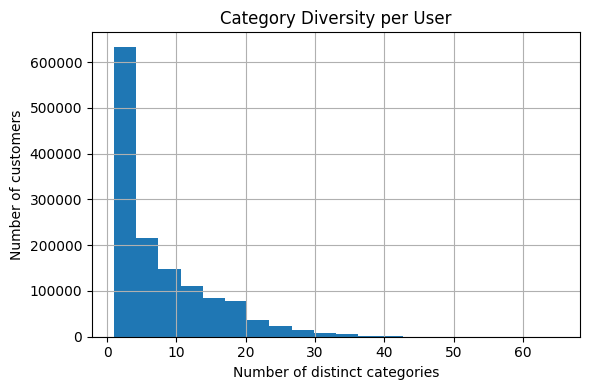

In [9]:
import matplotlib.pyplot as plt

# 1. Merge on product type
tx2 = tx.merge(arts[["article_id","product_type_name"]], on="article_id")

# 2. Count distinct categories per user
cat_div = (
    tx2.groupby("customer_id")["product_type_name"]
       .nunique()
       .rename("n_categories")
)

# 3. Distribution
plt.figure(figsize=(6,4))
cat_div.hist(bins=20)
plt.xlabel("Number of distinct categories")
plt.ylabel("Number of customers")
plt.title("Category Diversity per User")
plt.tight_layout()
plt.show()


In [11]:
# 1. Merge price (if in articles) into tx
tx_price = tx.merge(arts[["article_id"]], on="article_id")

# 2. Avg price per customer
cust_price = (
    tx_price.groupby("customer_id")["price"]
            .mean()
            .rename("avg_spend")
)

# 3. Segment & compare
high = cust_price.quantile(0.75)
low  = cust_price.quantile(0.25)

print("High-spender avg price:", cust_price[cust_price>=high].mean())
print("Low-spender avg price:" , cust_price[cust_price<=low].mean())


High-spender avg price: 0.04562158812901541
Low-spender avg price: 0.01640393964761807
